In [1]:
import matplotlib.pyplot as plt

In [552]:
import pandas as pd
import numpy as np
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv('raw data.csv', index_col=[0])

In [4]:
df = df[df['InvoiceDate'] <= '2011-12-01 23:59:59']

In [5]:
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']

In [6]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [7]:
invoice_count = df.groupby(['CustomerID'], as_index=False)['InvoiceNo'].count()

In [9]:
invoice_count.rename(columns={'InvoiceNo': 'frequency'}, inplace=True)

In [10]:
customer_total_revenue = df.groupby(['CustomerID'], as_index=False)['TotalRevenue'].sum()

In [11]:
customer_total_revenue.rename(columns={'TotalRevenue': 'monetary'}, inplace=True)

In [13]:
customer_total_revenue.monetary = round(customer_total_revenue.monetary, 2)

In [15]:
customer_total_revenue_invoice_count = customer_total_revenue.merge(invoice_count, on='CustomerID', sort=True)

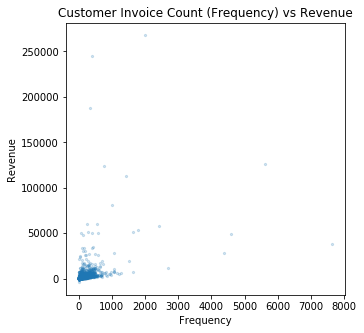

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(customer_total_revenue_invoice_count.frequency, customer_total_revenue_invoice_count.monetary, s=5, alpha=0.2)
plt.title('Customer Invoice Count (Frequency) vs Revenue')
plt.xlabel('Frequency')
plt.ylabel('Revenue')
plt.show()

In [22]:
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

In [23]:
df['DaysSincePurchase'] = df['InvoiceDate'].max() - df['InvoiceDate']

In [24]:
customer_since_purchase = df.groupby(['CustomerID'], as_index=False)['DaysSincePurchase'].min()

In [32]:
RecentPurchase = customer_since_purchase['DaysSincePurchase']

In [33]:
RecentPurchaseDays = [None] * len(RecentPurchase)

In [34]:
for i in range(len(RecentPurchase)):
    RecentPurchaseDays[i] = RecentPurchase[i].days

In [39]:
customer_total_revenue_invoice_count_since_purchase['recency'] = RecentPurchaseDays

In [44]:
customer_total_revenue_invoice_count_since_purchase['monetary'] = customer_total_revenue_invoice_count_since_purchase['monetary'].apply(lambda x: 0.01 if x <= 0 else x)

In [52]:
customer_total_revenue_invoice_count_since_purchase['recency'] = customer_total_revenue_invoice_count_since_purchase['recency'].apply(lambda x: 0.01 if x <= 0 else x)

# Log Transformation

In [84]:
log_features = pd.DataFrame()
log_features['monetary'] = np.log(customer_total_revenue_invoice_count_since_purchase['monetary'])
log_features['frequency'] = np.log(customer_total_revenue_invoice_count_since_purchase['frequency'])
log_features['recency'] = np.log(customer_total_revenue_invoice_count_since_purchase['recency'])
log_features['customers'] = customer_total_revenue_invoice_count_since_purchase.CustomerID
log_features.head()

,monetary,frequency,recency,customers
0,-4.605170,0.693147,5.758902,12346.0
1,8.315121,5.141664,3.433987,12347.0
2,7.494007,3.433987,4.204693,12348.0
3,7.471676,4.290459,2.302585,12349.0
4,5.812338,2.833213,5.710427,12350.0


# Standard Scaler

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [64]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(log_features)

# KMeans

In [68]:
from sklearn.metrics.cluster import adjusted_rand_score, calinski_harabaz_score


In [475]:
k_means_scaled = KMeans(n_clusters=6, n_init=300, max_iter = 1000, n_jobs = -1)
k_means_scaled.fit(scaled_df)

cluster_preds_scaled = k_means_scaled.predict(scaled_df)

In [476]:
log_features_with_preds = log_features.copy()

In [477]:
log_features_with_preds['clusters'] = cluster_preds_scaled

In [478]:
log_features_with_preds.head()

,monetary,frequency,recency,customers,clusters
0,-4.605170,0.693147,5.758902,12346.0,3
1,8.315121,5.141664,3.433987,12347.0,2
2,7.494007,3.433987,4.204693,12348.0,4
3,7.471676,4.290459,2.302585,12349.0,2
4,5.812338,2.833213,5.710427,12350.0,4


In [479]:
clustered_df = customer_total_revenue_invoice_count_since_purchase.merge(log_features_with_preds[['clusters', 'customers']], left_on='CustomerID', right_on='customers', sort=True)

In [480]:
clustered_df = customer_total_revenue_invoice_count_since_purchase.merge(
    log_features_with_preds[['clusters', 'customers']],
    left_on='CustomerID', right_on='customers', sort=True)

In [481]:
clustered_df.head()

,CustomerID,monetary,frequency,recency,clusters,customers
0,12346.0,0.01,2,317.0,3,12346.0
1,12347.0,4085.18,171,31.0,2,12347.0
2,12348.0,1797.24,31,67.0,4,12348.0
3,12349.0,1757.55,73,10.0,2,12349.0
4,12350.0,334.40,17,302.0,4,12350.0


In [482]:
clustered_df.drop(columns='customers', inplace=True)

In [483]:
clustered_df.groupby('clusters')['monetary'].sum()

clusters
0    2656006.50
1     357092.68
2    3407133.91
3          0.54
4     565016.65
5    1029298.87
Name: monetary, dtype: float64

In [484]:
str(round((clustered_df.groupby('clusters')['monetary'].sum()[0] / clustered_df['monetary'].sum()) * 100, 2))

'33.14'

In [485]:
for i in range(clustered_df['clusters'].nunique()):
    print('cluster ' + str(i) + ' monetary sum - ' + str(round(clustered_df.groupby('clusters')['monetary'].sum()[i], 2)))
    print('cluster ' + str(i) + ' monetary mean - ' + str(round(clustered_df.groupby('clusters')['monetary'].mean()[i], 2)))
    print('cluster ' + str(i) + ' frequency mean - ' + str(round(clustered_df.groupby('clusters')['frequency'].mean()[i])))
    print('cluster ' + str(i) + ' recency mean - ' + str(round(clustered_df.groupby('clusters')['recency'].mean()[i])))
    print('cluster ' + str(i) + ' count - ' + str(round(clustered_df.groupby('clusters')['recency'].count()[i])))
    print('cluster ' + str(i) + ' monetary percentage - ' + str(round((clustered_df.groupby('clusters')['monetary'].sum()[i] / clustered_df['monetary'].sum()) * 100, 2)))
    print('cluster ' + str(i) + ' count percentage - ' + str(round(clustered_df.groupby('clusters')['recency'].count()[i] / len(clustered_df) * 100, 2)))
    print('')

cluster 0 monetary sum - 2656006.5
cluster 0 monetary mean - 2445.68
cluster 0 frequency mean - 133.0
cluster 0 recency mean - 44.0
cluster 0 count - 1086
cluster 0 monetary percentage - 33.14
cluster 0 count percentage - 25.06

cluster 1 monetary sum - 357092.68
cluster 1 monetary mean - 356.74
cluster 1 frequency mean - 18.0
cluster 1 recency mean - 148.0
cluster 1 count - 1001
cluster 1 monetary percentage - 4.46
cluster 1 count percentage - 23.1

cluster 2 monetary sum - 3407133.91
cluster 2 monetary mean - 4003.68
cluster 2 frequency mean - 180.0
cluster 2 recency mean - 32.0
cluster 2 count - 851
cluster 2 monetary percentage - 42.51
cluster 2 count percentage - 19.64

cluster 3 monetary sum - 0.54
cluster 3 monetary mean - 0.01
cluster 3 frequency mean - 11.0
cluster 3 recency mean - 226.0
cluster 3 count - 54
cluster 3 monetary percentage - 0.0
cluster 3 count percentage - 1.25

cluster 4 monetary sum - 565016.65
cluster 4 monetary mean - 473.61
cluster 4 frequency mean - 24.0


In [159]:
round(clustered_df.groupby('clusters')['recency'].count()[0] / len(clustered_df) * 100, 2)


31.86

In [151]:
clustered_df.count()

CustomerID    4334
monetary      4334
frequency     4334
recency       4334
clusters      4334
dtype: int64

In [153]:
clustered_df['recency'].count()

4334

# Unscaled

In [226]:
k_means = KMeans(n_clusters=9, n_init=300, max_iter = 1000, n_jobs = -1)
k_means.fit(log_features)

cluster_preds = k_means.predict(log_features)

In [227]:
log_features_non_scaled_with_preds = log_features.copy()

In [228]:
log_features_non_scaled_with_preds['clusters'] = cluster_preds

In [229]:
clustered_df_non_scaled = customer_total_revenue_invoice_count_since_purchase.merge(log_features_non_scaled_with_preds[['clusters', 'customers']], left_on='CustomerID', right_on='customers', sort=True)

In [230]:
clustered_df_non_scaled.drop(columns='customers', inplace=True)

In [231]:
for i in range(clustered_df_non_scaled['clusters'].nunique()):
    print('cluster ' + str(i) + ' monetary sum - ' + str(round(clustered_df_non_scaled.groupby('clusters')['monetary'].sum()[i], 2)))
    print('cluster ' + str(i) + ' monetary mean - ' + str(round(clustered_df_non_scaled.groupby('clusters')['monetary'].mean()[i], 2)))
    print('cluster ' + str(i) + ' frequency mean - ' + str(round(clustered_df_non_scaled.groupby('clusters')['frequency'].mean()[i])))
    print('cluster ' + str(i) + ' recency mean - ' + str(round(clustered_df_non_scaled.groupby('clusters')['recency'].mean()[i])))
    print('cluster ' + str(i) + ' count - ' + str(round(clustered_df_non_scaled.groupby('clusters')['recency'].count()[i])))
    print('cluster ' + str(i) + ' monetary percentage - ' + str(round((clustered_df_non_scaled.groupby('clusters')['monetary'].sum()[i] / clustered_df_non_scaled['monetary'].sum()) * 100, 2)))
    print('cluster ' + str(i) + ' count percentage - ' + str(round(clustered_df_non_scaled.groupby('clusters')['recency'].count()[i] / len(clustered_df_non_scaled) * 100, 2)))
    print('')

cluster 0 monetary sum - 1079431.33
cluster 0 monetary mean - 2258.22
cluster 0 frequency mean - 116.0
cluster 0 recency mean - 84.0
cluster 0 count - 478
cluster 0 monetary percentage - 13.47
cluster 0 count percentage - 11.03

cluster 1 monetary sum - 746163.61
cluster 1 monetary mean - 1611.58
cluster 1 frequency mean - 83.0
cluster 1 recency mean - 87.0
cluster 1 count - 463
cluster 1 monetary percentage - 9.31
cluster 1 count percentage - 10.68

cluster 2 monetary sum - 760111.42
cluster 2 monetary mean - 1517.19
cluster 2 frequency mean - 88.0
cluster 2 recency mean - 94.0
cluster 2 count - 501
cluster 2 monetary percentage - 9.48
cluster 2 count percentage - 11.56

cluster 3 monetary sum - 927864.11
cluster 3 monetary mean - 1949.29
cluster 3 frequency mean - 95.0
cluster 3 recency mean - 99.0
cluster 3 count - 476
cluster 3 monetary percentage - 11.58
cluster 3 count percentage - 10.98

cluster 4 monetary sum - 978609.13
cluster 4 monetary mean - 2068.94
cluster 4 frequency mea

# HAC Methods

In [243]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity

In [294]:
agg_comp = AgglomerativeClustering(linkage ="complete", n_clusters=7, affinity='l2')
agg_avg = AgglomerativeClustering(linkage ="average", n_clusters=7, affinity='l2')
#  agg_ward = AgglomerativeClustering(linkage ="ward", n_clusters=7, affinity='l1')

as_comp = agg_comp.fit_predict(scaled_df)
as_avg = agg_avg.fit_predict(scaled_df)
#  as_ward = agg_ward.fit_predict(scaled_df)

In [295]:
HAC_scaled_comp = log_features.copy()

HAC_scaled_comp['comp'] = as_comp
HAC_scaled_comp['avg'] = as_avg
# HAC_scaled_comp['ward'] = as_ward

In [296]:
HAC_scaled_comp.head()

,monetary,frequency,recency,customers,comp,avg
0,-4.605170,0.693147,5.758902,12346.0,3,1
1,8.315121,5.141664,3.433987,12347.0,5,2
2,7.494007,3.433987,4.204693,12348.0,0,2
3,7.471676,4.290459,2.302585,12349.0,0,2
4,5.812338,2.833213,5.710427,12350.0,0,2


In [297]:
for i in range(HAC_scaled_comp['comp'].nunique()):
    print('cluster ' + str(i) + ' monetary sum - ' + str(round(HAC_scaled_comp.groupby('comp')['monetary'].sum()[i], 2)))
    print('cluster ' + str(i) + ' monetary mean - ' + str(round(HAC_scaled_comp.groupby('comp')['monetary'].mean()[i], 2)))
    print('cluster ' + str(i) + ' frequency mean - ' + str(round(HAC_scaled_comp.groupby('comp')['frequency'].mean()[i])))
    print('cluster ' + str(i) + ' recency mean - ' + str(round(HAC_scaled_comp.groupby('comp')['recency'].mean()[i])))
    print('cluster ' + str(i) + ' count - ' + str(round(HAC_scaled_comp.groupby('comp')['recency'].count()[i])))
    print('cluster ' + str(i) + ' monetary percentage - ' + str(round((HAC_scaled_comp.groupby('comp')['monetary'].sum()[i] / HAC_scaled_comp['monetary'].sum()) * 100, 2)))
    print('cluster ' + str(i) + ' count percentage - ' + str(round(HAC_scaled_comp.groupby('comp')['recency'].count()[i] / len(HAC_scaled_comp) * 100, 2)))
    print('')

cluster 0 monetary sum - 17406.68
cluster 0 monetary mean - 6.7
cluster 0 frequency mean - 4.0
cluster 0 recency mean - 4.0
cluster 0 count - 2597
cluster 0 monetary percentage - 62.65
cluster 0 count percentage - 59.92

cluster 1 monetary sum - 6184.81
cluster 1 monetary mean - 5.38
cluster 1 frequency mean - 2.0
cluster 1 recency mean - 5.0
cluster 1 count - 1150
cluster 1 monetary percentage - 22.26
cluster 1 count percentage - 26.53

cluster 2 monetary sum - 571.43
cluster 2 monetary mean - 7.23
cluster 2 frequency mean - 4.0
cluster 2 recency mean - -5.0
cluster 2 count - 79
cluster 2 monetary percentage - 2.06
cluster 2 count percentage - 1.82

cluster 3 monetary sum - -110.52
cluster 3 monetary mean - -4.61
cluster 3 frequency mean - 1.0
cluster 3 recency mean - 5.0
cluster 3 count - 24
cluster 3 monetary percentage - -0.4
cluster 3 count percentage - 0.55

cluster 4 monetary sum - 591.19
cluster 4 monetary mean - 8.45
cluster 4 frequency mean - 6.0
cluster 4 recency mean - -5.0

In [298]:
for i in range(HAC_scaled_comp['avg'].nunique()):
    print('cluster ' + str(i) + ' monetary sum - ' + str(round(HAC_scaled_comp.groupby('avg')['monetary'].sum()[i], 2)))
    print('cluster ' + str(i) + ' monetary mean - ' + str(round(HAC_scaled_comp.groupby('avg')['monetary'].mean()[i], 2)))
    print('cluster ' + str(i) + ' frequency mean - ' + str(round(HAC_scaled_comp.groupby('avg')['frequency'].mean()[i])))
    print('cluster ' + str(i) + ' recency mean - ' + str(round(HAC_scaled_comp.groupby('avg')['recency'].mean()[i])))
    print('cluster ' + str(i) + ' count - ' + str(round(HAC_scaled_comp.groupby('avg')['recency'].count()[i])))
    print('cluster ' + str(i) + ' monetary percentage - ' + str(round((HAC_scaled_comp.groupby('avg')['monetary'].sum()[i] / HAC_scaled_comp['monetary'].sum()) * 100, 2)))
    print('cluster ' + str(i) + ' count percentage - ' + str(round(HAC_scaled_comp.groupby('avg')['recency'].count()[i] / len(HAC_scaled_comp) * 100, 2)))
    print('')

cluster 0 monetary sum - 66.42
cluster 0 monetary mean - 11.07
cluster 0 frequency mean - 8.0
cluster 0 recency mean - -5.0
cluster 0 count - 6
cluster 0 monetary percentage - 0.24
cluster 0 count percentage - 0.14

cluster 1 monetary sum - -248.68
cluster 1 monetary mean - -4.61
cluster 1 frequency mean - 1.0
cluster 1 recency mean - 5.0
cluster 1 count - 54
cluster 1 monetary percentage - -0.89
cluster 1 count percentage - 1.25

cluster 2 monetary sum - 26146.1
cluster 2 monetary mean - 6.5
cluster 2 frequency mean - 4.0
cluster 2 recency mean - 4.0
cluster 2 count - 4020
cluster 2 monetary percentage - 94.1
cluster 2 count percentage - 92.75

cluster 3 monetary sum - 266.34
cluster 3 monetary mean - 10.65
cluster 3 frequency mean - 6.0
cluster 3 recency mean - 2.0
cluster 3 count - 25
cluster 3 monetary percentage - 0.96
cluster 3 count percentage - 0.58

cluster 4 monetary sum - 8.04
cluster 4 monetary mean - 8.04
cluster 4 frequency mean - 0.0
cluster 4 recency mean - 5.0
cluster 

In [285]:
for i in range(HAC_scaled_comp['avg'].nunique()):
    print('cluster ' + str(i) + ' monetary sum - ' + str(round(HAC_scaled_comp.groupby('ward')['monetary'].sum()[i], 2)))
    print('cluster ' + str(i) + ' monetary mean - ' + str(round(HAC_scaled_comp.groupby('ward')['monetary'].mean()[i], 2)))
    print('cluster ' + str(i) + ' frequency mean - ' + str(round(HAC_scaled_comp.groupby('ward')['frequency'].mean()[i])))
    print('cluster ' + str(i) + ' recency mean - ' + str(round(HAC_scaled_comp.groupby('ward')['recency'].mean()[i])))
    print('cluster ' + str(i) + ' count - ' + str(round(HAC_scaled_comp.groupby('ward')['recency'].count()[i])))
    print('cluster ' + str(i) + ' monetary percentage - ' + str(round((HAC_scaled_comp.groupby('ward')['monetary'].sum()[i] / HAC_scaled_comp['monetary'].sum()) * 100, 2)))
    print('cluster ' + str(i) + ' count percentage - ' + str(round(HAC_scaled_comp.groupby('ward')['recency'].count()[i] / len(HAC_scaled_comp) * 100, 2)))
    print('')

cluster 0 monetary sum - 8059.98
cluster 0 monetary mean - 6.63
cluster 0 frequency mean - 4.0
cluster 0 recency mean - 4.0
cluster 0 count - 1215
cluster 0 monetary percentage - 29.01
cluster 0 count percentage - 28.03

cluster 1 monetary sum - 6962.06
cluster 1 monetary mean - 7.87
cluster 1 frequency mean - 5.0
cluster 1 recency mean - 2.0
cluster 1 count - 885
cluster 1 monetary percentage - 25.06
cluster 1 count percentage - 20.42

cluster 2 monetary sum - 3428.35
cluster 2 monetary mean - 5.37
cluster 2 frequency mean - 2.0
cluster 2 recency mean - 5.0
cluster 2 count - 638
cluster 2 monetary percentage - 12.34
cluster 2 count percentage - 14.72

cluster 3 monetary sum - -248.68
cluster 3 monetary mean - -4.61
cluster 3 frequency mean - 1.0
cluster 3 recency mean - 5.0
cluster 3 count - 54
cluster 3 monetary percentage - -0.89
cluster 3 count percentage - 1.25

cluster 4 monetary sum - 1162.61
cluster 4 monetary mean - 7.8
cluster 4 frequency mean - 5.0
cluster 4 recency mean - -

In [299]:
HAC_scaled_comp

,monetary,frequency,recency,customers,comp,avg
0,-4.605170,0.693147,5.758902,12346.0,3,1
1,8.315121,5.141664,3.433987,12347.0,5,2
2,7.494007,3.433987,4.204693,12348.0,0,2
3,7.471676,4.290459,2.302585,12349.0,0,2
4,5.812338,2.833213,5.710427,12350.0,0,2
5,7.343045,4.553877,3.332205,12352.0,0,2
6,4.488636,1.386294,5.278115,12353.0,1,2
7,6.984161,4.060443,5.411646,12354.0,0,2
8,6.129921,2.564949,5.327876,12355.0,0,2
9,7.941449,4.077537,2.639057,12356.0,0,2


# Simple "Top 20%" Method

In [309]:
top_20_sorting = customer_total_revenue_invoice_count_since_purchase.sort_values('monetary', ascending=False).reset_index().copy()

In [313]:
top_20_sorting.rename(index = str, columns = {"index": "customer"}, inplace = True)

In [351]:
top_20_money = 0
top_20_company_money = []

top_20_biz = 0
top_20_company_biz = []


In [355]:
for i in range(len(top_20_sorting['monetary'])):
    if top_20_money < (top_20_sorting['monetary'].sum() * .8):
        top_20_money += top_20_sorting['monetary'][i]
        top_20_company_money.append(top_20_sorting['customer'][i])
    else:
        break
        
for i in range(len(top_20_sorting['monetary'])):
    if top_20_biz < (len(top_20_sorting['monetary']) * .2):
        top_20_biz += top_20_sorting['monetary'][i]
        top_20_company_biz.append(top_20_sorting['customer'][i])
    else:
        break

In [361]:
print('percentage of companies: ' + str(len(top_20_company_money) / len(top_20_sorting) * 100))
print('percentage of money: ' + str(top_20_money / sum(top_20_sorting['monetary']) * 100))
print('')
print('percentage of companies: ' + str(len(top_20_company_biz) / len(top_20_sorting) * 100))
print('percentage of money: ' + str(top_20_biz / sum(top_20_sorting['monetary']) * 100))

percentage of companies: 27.18043377941855
percentage of money: 80.00779831763822

percentage of companies: 23.211813567143516
percentage of money: 80.01130968171792


In [383]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [384]:
v = np.random.rand(10,4)
v[:,3] = np.random.randint(0,2,size=10)
df = pd.DataFrame(v, columns=['Feature1', 'Feature2','Feature3',"Cluster"])
print (df)

   Feature1  Feature2  Feature3  Cluster
0  0.489833  0.698508  0.907520      1.0
1  0.798052  0.158119  0.792419      0.0
2  0.182593  0.594693  0.113019      1.0
3  0.273946  0.580358  0.835704      0.0
4  0.860932  0.196390  0.544923      0.0
5  0.407135  0.181797  0.300051      1.0
6  0.626369  0.999623  0.784751      0.0
7  0.777182  0.058646  0.929146      1.0
8  0.045920  0.449053  0.160552      1.0
9  0.938508  0.892005  0.163654      1.0


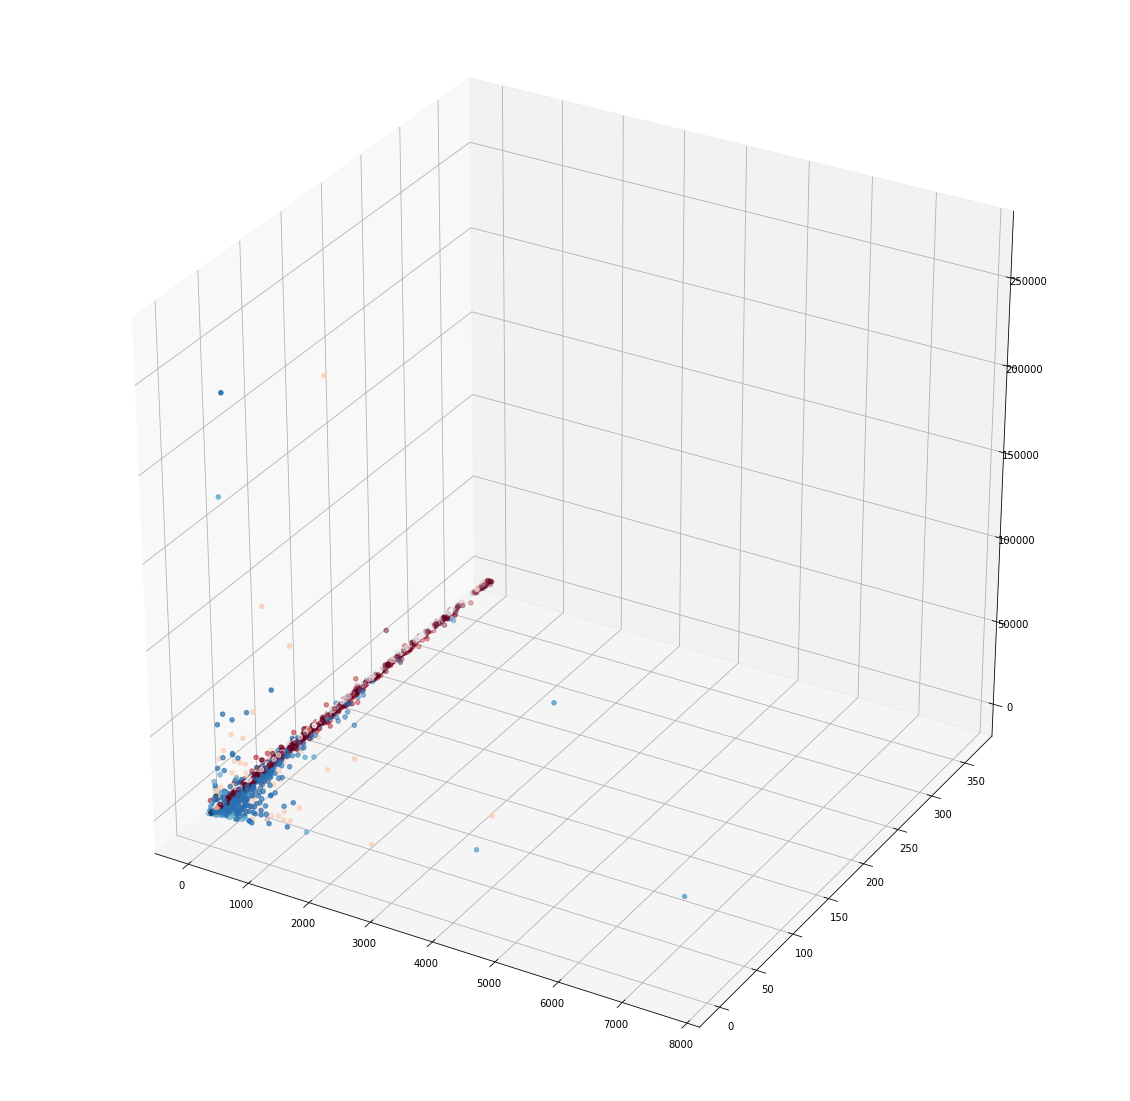

In [397]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

x = np.array(clustered_df['frequency'])
y = np.array(clustered_df['recency'])
z = np.array(clustered_df['monetary'])

ax.scatter(x,y,z, c=clustered_df["clusters"], s=20, cmap="RdBu")

plt.show()

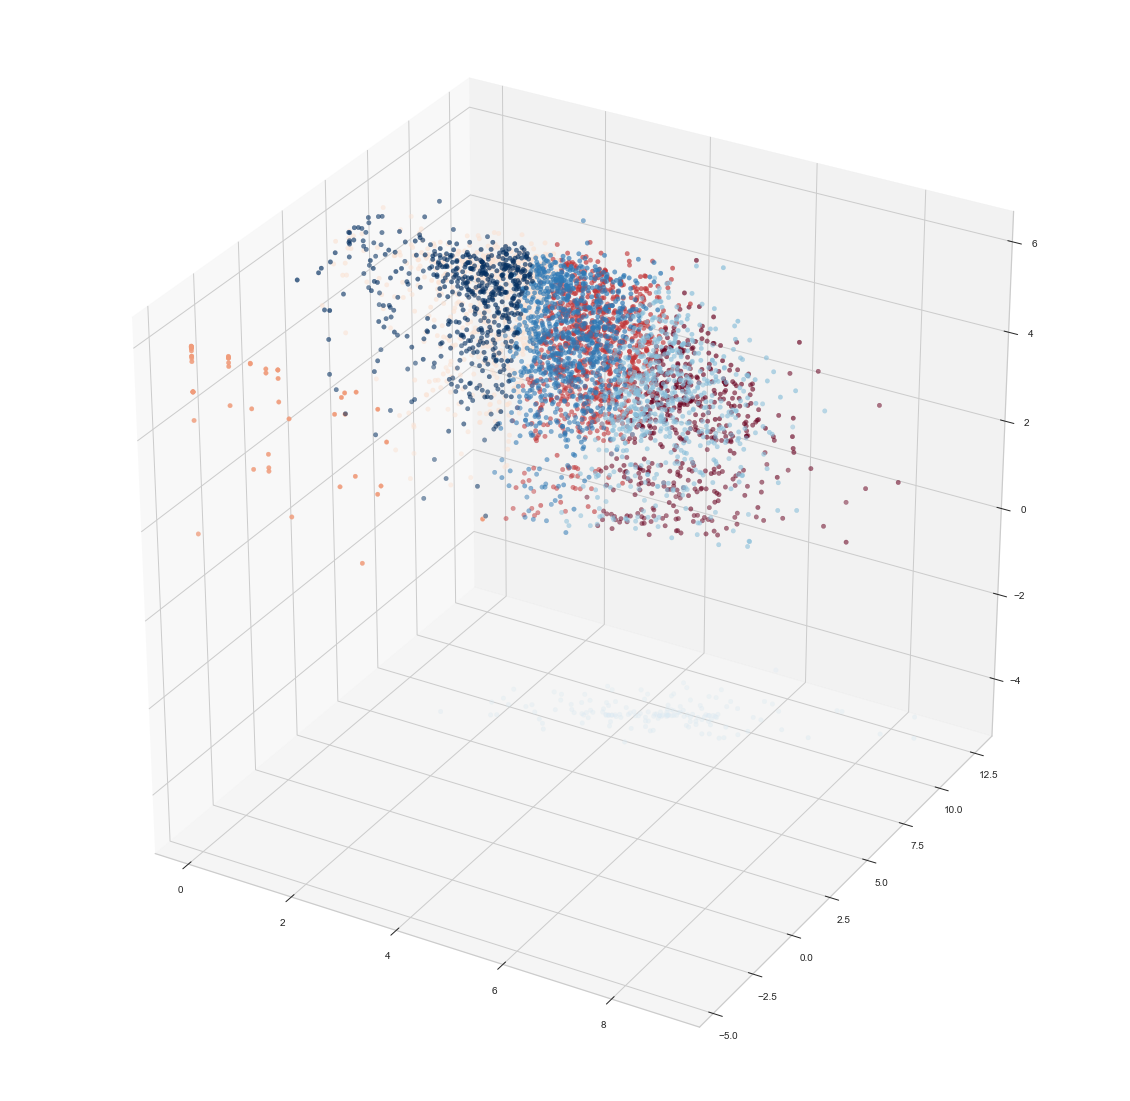

In [550]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

x = np.array(log_features_with_preds['frequency'])
y = np.array(log_features_with_preds['monetary'])
z = np.array(log_features_with_preds['recency'])

ax.scatter(x,y,z, c=log_features_with_preds["clusters"], s=20, cmap="RdBu")

plt.show()

# KMeans Loop

In [413]:
from sklearn.metrics import silhouette_score

In [414]:
evaluate_df = customer_total_revenue_invoice_count_since_purchase.set_index('CustomerID').copy()

In [501]:
for i in range(2,11):
    k_means_scaled = KMeans(n_clusters=i, n_init=100, max_iter = 1000, n_jobs = -1)
    k_means_scaled.fit(scaled_df)

    cluster_preds_scaled = k_means_scaled.predict(scaled_df)
    
    labels = k_means.labels_

    # Call silhouette_score() below!
    print(silhouette_score(X, labels, metric='euclidean'))

0.013778504850421208
0.013778504850421208
0.013778504850421208
0.013778504850421208
0.013778504850421208
0.013778504850421208
0.013778504850421208
0.013778504850421208
0.013778504850421208


In [502]:
km = KMeans(n_clusters=3)
km.fit(scaled_df)
labels = km.predict(scaled_df)
centroids = km.cluster_centers_

In [455]:
from yellowbrick.cluster import KElbowVisualizer

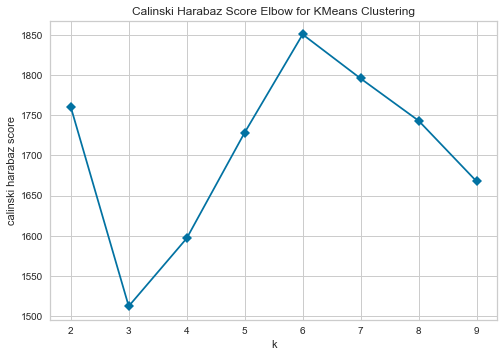

In [561]:
model = KMeans(n_jobs = -1, n_init=100)
visualizer = KElbowVisualizer(
    model, k=(2,10), metric='calinski_harabaz', timings=False
)

visualizer.fit(scaled_df)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [517]:
compare_df = customer_total_revenue_invoice_count_since_purchase.set_index('CustomerID').copy()

In [528]:
from sklearn.metrics.cluster import calinski_harabasz_score

In [562]:
for j in range(3,7):
    for l in range (0,2):
        for m in range (0,3):

            algo = ["auto", "full", "elkan"]
            
            list_of_inits = ['k-means++', 'random']

            k_means_scaled = KMeans(n_clusters=j, n_init=100, max_iter = 1000, n_jobs = -1, init = list_of_inits[l], algorithm = algo[m])
            k_means_scaled.fit(scaled_df)

            cluster_preds_scaled = k_means_scaled.predict(scaled_df)

            log_features_non_scaled_with_preds = log_features.copy()

            log_features_with_preds['clusters'] = cluster_preds_scaled

            clustered_df = customer_total_revenue_invoice_count_since_purchase.merge(log_features_with_preds[['clusters', 'customers']], left_on='CustomerID', right_on='customers', sort=True)

            clustered_df = customer_total_revenue_invoice_count_since_purchase.merge(
            log_features_with_preds[['clusters', 'customers']],
            left_on='CustomerID', right_on='customers', sort=True)

            clustered_df.drop(columns='customers', inplace=True)

            print(str(j) + ' clusters with ' + list_of_inits[l] + ' ' + algo[m])
            print('silhouette: '+ str(metrics.silhouette_score(scaled_df, cluster_preds_scaled)))
            print('CH score: '+ str(calinski_harabasz_score(scaled_df, cluster_preds_scaled)))
            print('')

#             for i in range(clustered_df['clusters'].nunique()):
#         #         print('cluster ' + str(i) + ' monetary sum - ' + str(round(clustered_df.groupby('clusters')['monetary'].sum()[i], 2)))
#         #         print('cluster ' + str(i) + ' monetary mean - ' + str(round(clustered_df.groupby('clusters')['monetary'].mean()[i], 2)))
#         #         print('cluster ' + str(i) + ' frequency mean - ' + str(round(clustered_df.groupby('clusters')['frequency'].mean()[i])))
#         #         print('cluster ' + str(i) + ' recency mean - ' + str(round(clustered_df.groupby('clusters')['recency'].mean()[i])))
#         #         print('cluster ' + str(i) + ' count - ' + str(round(clustered_df.groupby('clusters')['recency'].count()[i])))
#                 print('cluster ' + str(i) + ' monetary percentage - ' + str(round((clustered_df.groupby('clusters')['monetary'].sum()[i] / clustered_df['monetary'].sum()) * 100, 2)))
#                 print('cluster ' + str(i) + ' count percentage - ' + str(round(clustered_df.groupby('clusters')['recency'].count()[i] / len(clustered_df) * 100, 2)))
#                 print('')

3 clusters with k-means++ auto
silhouette: 0.24880281846886412
CH score: 1511.8951389431274

3 clusters with k-means++ full
silhouette: 0.24897663896696912
CH score: 1511.8877673799325

3 clusters with k-means++ elkan
silhouette: 0.24883590782517476
CH score: 1511.9023970016815

3 clusters with random auto
silhouette: 0.24885028374659418
CH score: 1511.8984635668205

3 clusters with random full
silhouette: 0.24880984947320495
CH score: 1511.8802621639468

3 clusters with random elkan
silhouette: 0.24881544447754786
CH score: 1511.8983594693175

4 clusters with k-means++ auto
silhouette: 0.26754913873215364
CH score: 1596.5654797571601

4 clusters with k-means++ full
silhouette: 0.26748439866374224
CH score: 1596.562169785765

4 clusters with k-means++ elkan
silhouette: 0.26759724715373434
CH score: 1596.582461519667

4 clusters with random auto
silhouette: 0.2674411441178792
CH score: 1596.457915150488

4 clusters with random full
silhouette: 0.267875709010134
CH score: 1596.5610454204

In [518]:
compare_df.head(2)

,monetary,frequency,recency
CustomerID,,,
12346.0,0.01,2,317.0
12347.0,4085.18,171,31.0


In [532]:
!pip install hdbscan

     |████████████████████████████████| 4.0MB 3.5MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Stored in directory: /Users/robblatt/Library/Caches/pip/wheels/6d/f9/db/f2e5e704427932f5b05c91fc520effbb0bd10ba8d73fd3bfc7
Successfully built hdbscan


In [533]:
import hdbscan

/Users/robblatt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/robblatt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [534]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(scaled_df)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [536]:
# HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
#     gen_min_span_tree=True, leaf_size=40, memory=Memory(cachedir=None),
#     metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

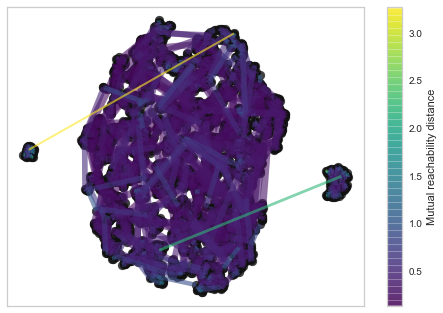

In [537]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

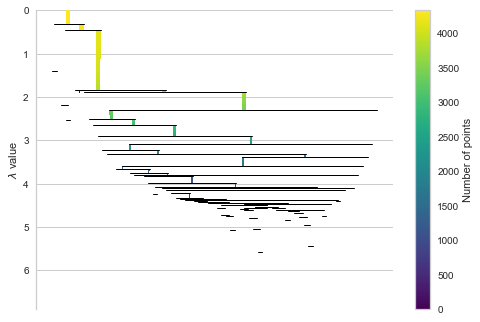

In [539]:
clusterer.condensed_tree_.plot()

In [541]:
import seaborn as sns

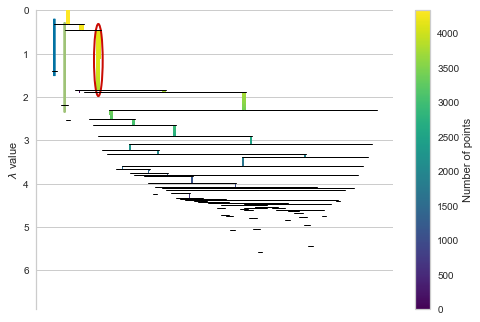

In [542]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

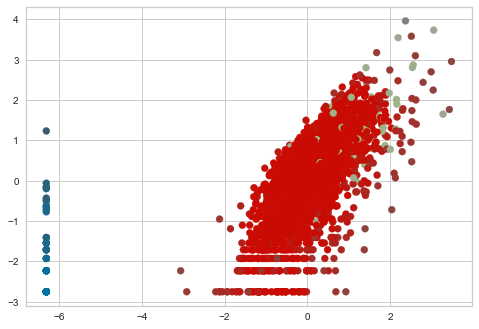

In [546]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(scaled_df.T[0], scaled_df.T[1], c=cluster_colors,)